In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from aeon.utils.numba.general import z_normalise_series_2d

# from aeon.distances import euclidean_distance
# from aeon.distances import dtw_distance
from aeon.distances import get_distance_function

In [2]:
%load_ext autoreload
%autoreload 2

from ksfdtw.distance_measures import psdtw_prime_vanilla as psdtw_prime_vanilla, psedd_prime as psedd_prime
from ksfdtw.utils import precision_at_k

In [3]:
# A neat way to load the dataset, but more complicated to use
# data = np.load("../data_intermediate/GunPoint_preprocessed_P_3_l_2.0_len_150.npz")
# data_dict = {key: data[key] for key in data.files}

# A old way to load the dataset
data = np.load(
    "../data_intermediate/GunPoint_preprocessed_P_3_l_2.0_len_150.npz",
    allow_pickle=True,
)
X_train_scaled = data["X_train_scaled"]
X_train_ps = data["X_train_ps"]
X_train_ps_noise = data["X_train_ps_noise"]
y_train = data["y_train"]
X_test_scaled = data["X_test_scaled"]
X_test_ps = data["X_test_ps"]
X_test_ps_noise = data["X_test_ps_noise"]
y_test = data["y_test"]
X_train_cuts = data["X_train_cuts"].tolist()
X_train_ps_cuts = data["X_train_ps_cuts"].tolist()
X_test_cuts = data["X_test_cuts"].tolist()
X_test_ps_cuts = data["X_test_ps_cuts"].tolist()

In [4]:
X_train_scaled.shape, X_train_ps.shape, X_train_ps_noise.shape

((50, 150), (50, 150), (50, 150))

In [5]:
X_train_scaled.shape

(50, 150)

In [6]:
X_train_scaled_norm = z_normalise_series_2d(X_train_scaled)
X_train_ps_norm = z_normalise_series_2d(X_train_ps)
X_train_ps_noise_norm = z_normalise_series_2d(X_train_ps_noise)

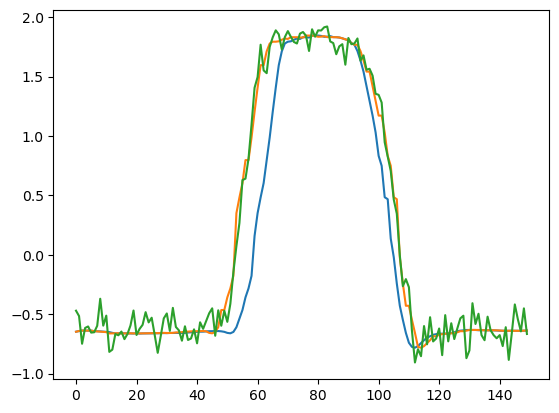

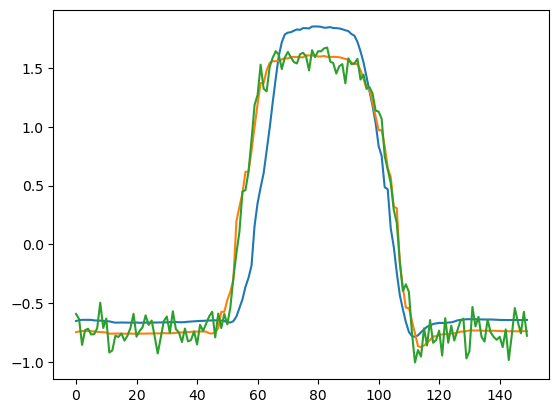

In [7]:
instance_idx = 0
plt.plot(X_train_scaled[instance_idx])
plt.plot(X_train_ps[instance_idx])
plt.plot(X_train_ps_noise[instance_idx])
plt.show()
plt.plot(X_train_scaled_norm[instance_idx])
plt.plot(X_train_ps_norm[instance_idx])
plt.plot(X_train_ps_noise_norm[instance_idx])
plt.show()

In [ ]:
# *** Change here 1 ***
# Query set
# query_set = X_train_ps
query_set = X_train_ps_norm
# query_set = X_train_ps_noise
# query_set = X_train_ps_noise_norm


# Target set
# target_set = X_train_scaled
target_set = X_train_scaled_norm
if len(query_set) != len(target_set):
    raise ValueError("query_set and target_set have different sizes!")

In [9]:
# Q = query_set[0]
# C = target_set[0]
# psdtw_prime(Q, C, l=2, P=3, r=0.1)

# Precision@k

Compute $P@k$ for querying $Q \in$ `query_set` using `method_name` on `target_set`

In [ ]:
# *** Change here 2 ***
# https://www.aeon-toolkit.org/en/stable/api_reference/auto_generated/aeon.distances.get_distance_function.html
# **aeon**
# --------------------- Step 1 ---------------------
method_name = "dtw"
# method_name = "shape_dtw"
# method_name = "ddtw"
# method_name = "wdtw"
# method_name = "wddtw"
# method_name = "adtw"
# method_name = "erp"
# method_name = "edr"
# method_name = "msm"
# method_name = "twe"
# method_name = "lcss"
# --------------------- Step 2 ---------------------
dist_func_prime = get_distance_function(method_name)
dist_func = lambda Q, C: dist_func_prime(Q, C, window=0.1)

In [ ]:
# *euclidean*
# dist_func = get_distance_function("euclidean")

# *manhattan*
# dist_func = get_distance_function("manhattan")

# *minkowski*
# dist_func = get_distance_function("minkowski")

# *sbd*
# dist_func = get_distance_function("sbd")

In [ ]:
# --------------------- Step 1 ---------------------
# *psed*
# method_name = "psed"
# dist_func = lambda Q, C: psdtw_prime_vanilla(Q, C, l=2, P=3, r=0.1, dist_method=0)

# *psdtw*
# method_name = "psdtw"
# dist_func_p = lambda Q, C: psdtw_prime_vanilla(Q, C, l=2, P=3, r=0.1, dist_method=1)
# --------------------- Step 2 ---------------------
# def dist_func(Q, C):
#     dist, _, _ = dist_func_p(Q, C)
#     return dist

In [ ]:
# *psedd*
# method_name = "psedd"
# dist_func = lambda Q, C: psedd_prime(Q, C, l=2, P=3, r=0.1)

In [ ]:
%%time
precision_at_1, precision_at_3, precision_at_5, precision_at_7 = 0, 0, 0, 0
for i in range(0, len(query_set)):
    # *** Change here 3 ***
    distances = np.array([dist_func(query_set[i], x) for x in target_set])
    
    # results = [dist_func(query_set[i], x) for x in target_set]
    # dist_arr, count_dist_calls_arr, cuts_arr = zip(*results)
    # distances = np.array(dist_arr)

    # distances = np.array(results)
    precision_at_1 += precision_at_k(distances, i, 1)
    precision_at_3 += precision_at_k(distances, i, 3)
    precision_at_5 += precision_at_k(distances, i, 5)
    precision_at_7 += precision_at_k(distances, i, 7)
print(
    f"{precision_at_1 / len(query_set):.2f},",
    f"{precision_at_3 / len(query_set):.2f},",
    f"{precision_at_5 / len(query_set):.2f},",
    f"{precision_at_7 / len(query_set):.2f}",
)

0.42, 0.60, 0.70, 0.82
CPU times: user 42min 34s, sys: 18.8 s, total: 42min 53s
Wall time: 43min 25s


In [ ]:
# # Save precision results to CSV
# num_queries = len(query_set)
# row = {
#     "precision_at_1": precision_at_1 / num_queries,
#     "precision_at_3": precision_at_3 / num_queries,
#     "precision_at_5": precision_at_5 / num_queries,
#     "precision_at_7": precision_at_7 / num_queries,
# }

# # Ensure the folder exists
# os.makedirs("../results_temp", exist_ok=True)

# csv_path = "../results_temp/" + method_name + ".csv"
# pd.DataFrame([row]).to_csv(
#     csv_path,
#     mode="a",
#     index=False,
#     header=not os.path.exists(csv_path),
# )
# print(f"Saved to {csv_path}")

In [ ]:
# *** Change here 4 ***
# Save whole results to NPZ
# Ensure the folder exists
os.makedirs("../results", exist_ok=True)
np.savez(
    "../results/X_train_ps_noise_norm_"+method_name+".npz", results=np.array(results, dtype=object)
    "../results/X_train_ps_norm_"+method_name+".npz", results=np.array(results, dtype=object)
)

# Pruning (Only for PSED, and PSDW)
Since PSEDD uses the cut of PSED as input, their "total_count_dist_calls" are the same.

In [ ]:
# data = np.load(f"../results/X_train_ps_noise_norm_{method_name}.npz", allow_pickle=True)
# data = np.load(f"../results/X_train_ps_norm_{method_name}.npz", allow_pickle=True)
# results = data["results"]

In [ ]:
# *** Change here 5 ***
total_count_dist_calls = 0
for r in results:
    total_count_dist_calls += r[1]
print(total_count_dist_calls)

94526106


In [16]:
import datetime

print(f"This notebook was last run end-to-end on: {datetime.datetime.now()}\n")
###
###
###

This notebook was last run end-to-end on: 2025-09-09 19:50:41.630292

